# Линейная регрессия: переобучение и регуляризация

## Задание: 
настройка линейной модели для прогнозирования количества прокатов велосипедов в зависимости от календарных характеристик дня и погодных условий  

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('Linear_Regression_(part3)_(bikes_rent).csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
season            731 non-null int64
yr                731 non-null int64
mnth              731 non-null int64
holiday           731 non-null int64
weekday           731 non-null int64
workingday        731 non-null int64
weathersit        731 non-null int64
temp              731 non-null float64
atemp             731 non-null float64
hum               731 non-null float64
windspeed(mph)    731 non-null float64
windspeed(ms)     731 non-null float64
cnt               731 non-null int64
dtypes: float64(5), int64(8)
memory usage: 74.4 KB


##### Для каждого дня проката известны следующие признаки:

season: 1 - весна, 2 - лето, 3 - осень, 4 - зима

yr: 0 - 2011, 1 - 2012

mnth: от 1 до 12

holiday: 0 - нет праздника, 1 - есть праздник

weekday: от 0 до 6

workingday: 0 - нерабочий день, 1 - рабочий день

weathersit: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)

temp: температура в Цельсиях

atemp: температура по ощущениям в Цельсиях

hum: влажность

windspeed(mph): скорость ветра в милях в час

windspeed(ms): скорость ветра в метрах в секунду

cnt: количество арендованных велосипедов

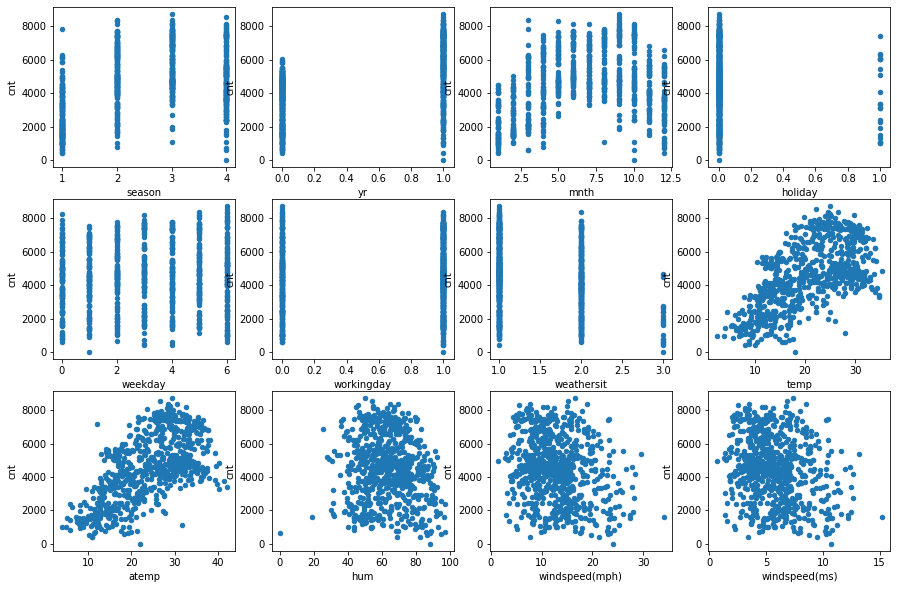

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

#### Выводы:
1. Наблюдается явная сезонность: с марта по июнь число прокатов растет, затем вплоть до сентября показатели стабильны, после чего они снижаются с наступлением холодов вплоть до весны.
2. Число прокатов достаточно линейно зависит от температуры и температуры по ощущениям (temp и atemp)

### Оценка корреляционной зависимости

In [5]:
df.corr()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659


In [6]:
corr=pd.DataFrame(df.drop('cnt', axis=1)).corrwith(df.cnt)
corr=pd.DataFrame(corr)
corr.columns=['cnt']
corr.sort_values('cnt')

,cnt
weathersit,-0.297391
windspeed(ms),-0.234545
windspeed(mph),-0.234545
hum,-0.100659
holiday,-0.068348
workingday,0.061156
weekday,0.067443
mnth,0.279977
season,0.406100
yr,0.566710


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методам.
Также по графикам видно, что некоторые признаки похожи друг на друга. Поэтому также посчитаем корреляции между вещественными признаками

In [7]:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Этот факт негативно сказывается на обучении линейной модели

In [8]:
df.apply(np.mean)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы лучше нормировать матрицу объекты-признаки

### Проблема первая: коллинеарные признаки
В данных один признак дублирует другой, и есть еще два очень похожих. Конечно, можно сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

#### Масштабирование признаков
Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

In [9]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [10]:
x = scale(df[df.columns[:-1]]) # стандартизация всех признаков, кроме целевого 'cnt'
y = df["cnt"]

#### Обучение линейной регрессии

In [11]:
from sklearn import linear_model

In [12]:
linear_regressor=linear_model.LinearRegression()
linear_regressor.fit(x,y)
list(zip(linear_regressor.coef_, df.columns))

[(570.8705744929921, 'season'),
 (1021.959184453726, 'yr'),
 (-141.30502511524503, 'mnth'),
 (-86.75744720349323, 'holiday'),
 (137.22662551096067, 'weekday'),
 (56.3910061965351, 'workingday'),
 (-330.2310362473084, 'weathersit'),
 (367.49202357022045, 'temp'),
 (585.5369115245651, 'atemp'),
 (-145.60912610327284, 'hum'),
 (12457934448658.908, 'windspeed(mph)'),
 (-12457934448857.361, 'windspeed(ms)')]

Видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. 
Такая ситуация называется проблемой мультиколлиниартости.
Решение проблемы мультиколлинеарности состоит в регуляризации линейной модели. К оптимизируемому функционалу прибавляют L1 (метод Lasso) или L2 (метод Ridge), умноженную на коэффициент регуляризации  α.
#### Обучение регрессора с помощью методов  Lasso и Ridge

In [13]:
# метод lasso
lasso_linear_regressor=linear_model.Lasso()
lasso_linear_regressor.fit(x,y)
list(zip(lasso_linear_regressor.coef_,df.columns))

[(560.2416160308859, 'season'),
 (1019.4634940657194, 'yr'),
 (-128.73062703678684, 'mnth'),
 (-86.152781333711, 'holiday'),
 (137.34789390496314, 'weekday'),
 (55.212370641356564, 'workingday'),
 (-332.3698569623485, 'weathersit'),
 (376.36323620969785, 'temp'),
 (576.5307935045519, 'atemp'),
 (-144.12915500348606, 'hum'),
 (-197.13968940249467, 'windspeed(mph)'),
 (-2.804104795025868e-08, 'windspeed(ms)')]

In [14]:
# метод Ridge
ridge_linear_regressor=linear_model.Ridge()
ridge_linear_regressor.fit(x,y)
list(zip(ridge_linear_regressor.coef_,df.columns))

[(563.0645722520144, 'season'),
 (1018.9483787875288, 'yr'),
 (-131.8733202824729, 'mnth'),
 (-86.74609799709246, 'holiday'),
 (138.00511117871912, 'weekday'),
 (55.90311037506469, 'workingday'),
 (-332.3497884990733, 'weathersit'),
 (386.45788919190437, 'temp'),
 (566.347047060071, 'atemp'),
 (-145.0713272986728, 'hum'),
 (-99.25944108182254, 'windspeed(mph)'),
 (-99.25944115430993, 'windspeed(ms)')]

### Проблема вторая: неинформативные признаки
#### Пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации  α

In [15]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], x.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], x.shape[1]))

In [16]:
# Для каждого значения коэффициента из alphas обучим регрессор Lasso 
# и запишем веса в соответствующую строку матрицы coefs_lasso.
# Затем обучите Ridge и запишем веса в coefs_ridge.
i = 0
for alpha in alphas:
    reg_lasso = linear_model.Lasso(alpha = alpha)
    reg_lasso.fit(x, y)
    coefs_lasso[i, :] = reg_lasso.coef_
    
    reg_ridge = linear_model.Ridge(alpha = alpha)
    reg_ridge.fit(x, y)
    coefs_ridge[i, :] = reg_ridge.coef_
    i += 1

#### Визуализация динамики весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

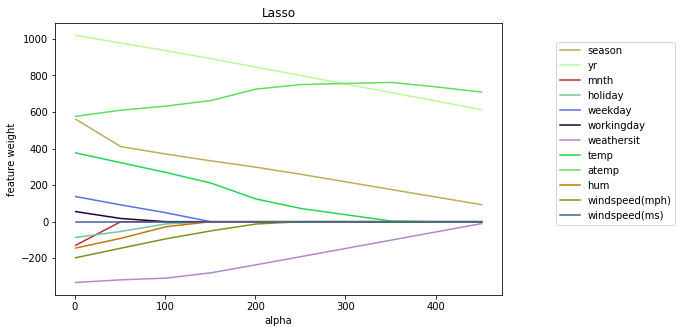

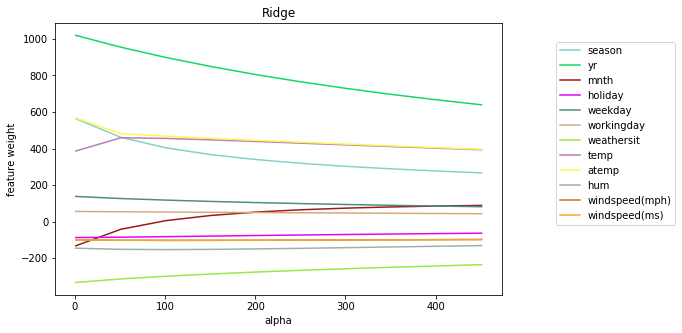

In [17]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

#### Выводы:
1. Lasso (L1) классификатор более агрессивно уменьшает веса, чем Ridge (L2) классификотор
2. Если alpha сделать очень большим, весса Lasso будут равны 0. Особенностью Lasso регуляризации является отбор признаков, который вызван ромбообразными линиями уровня L1 нормы. То бишь, в этом случае слагамое, отвечающее за регуляризацию, будет сильно больше среднеквадратичной ошибки, а оптимальное значение этого слагаемого достигается при нулевых весах.
3. При Lasso регуляризации вес при признаке windspeed(ms) равен 0 при всех рассматриваемых alpha. В случае Ridge регуляризации коэффициенты при переменных windspeed(ms) и windspeed(mph) отличны от 0.
4. Lasso (L1) регуляризатор подойдет для отбора признаков, поскольку он агрессивнее уменьшает веса и выставляет их равными 0

##### Далее будем работать с Lasso для  выбора наилучших alpha для подбора коэффициэнтов признаков
Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, LassoCV, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную mse_path_, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha_ будет храниться выбранное значение параметра регуляризации, а в coef_, традиционно, обученные веса, соответствующие этому alpha_.

Так как регрессор может менять порядок, в котором он проходит по alphas, для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [18]:
from sklearn.linear_model import LassoCV

Text(0.5, 1.0, 'Lasso')

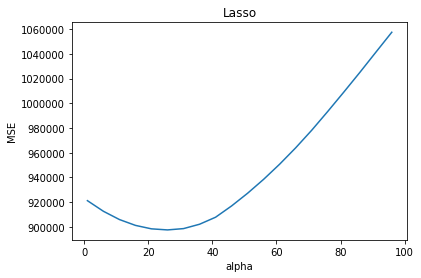

In [19]:
alphas = np.arange(1, 100, 5)
lassocv_reg = LassoCV(alphas = alphas, cv=3)
lassocv_reg.fit(x, y)
mean_mse = np.mean(lassocv_reg.mse_path_, axis = 1)
plt.plot(lassocv_reg.alphas_, mean_mse) # график усредненного по строкам MSE в зависимости от alpha
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Lasso')

#### Вывод выбранных alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов

In [20]:
print ('alpha = ', lassocv_reg.alpha_)
fin_coefs = pd.DataFrame(zip(lassocv_reg.coef_, df.columns))
fin_coefs.columns = ['weight', 'feature']
fin_coefs.set_index('feature').sort_values('weight')

alpha =  26


,weight
feature,
weathersit,-3.236791e+02
windspeed(mph),-1.704494e+02
hum,-1.224174e+02
holiday,-7.147585e+01
windspeed(ms),-2.257475e-08
mnth,-0.000000e+00
workingday,3.683136e+01
weekday,1.134124e+02
temp,3.483124e+02


#### Посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

MSE min alpha values [56 41  1]


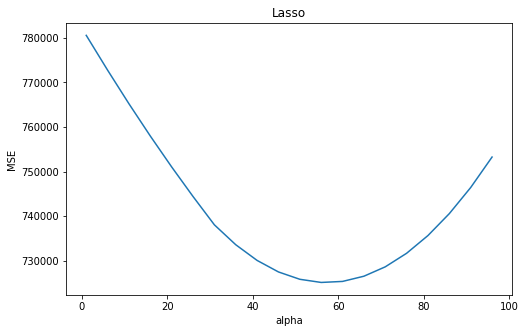

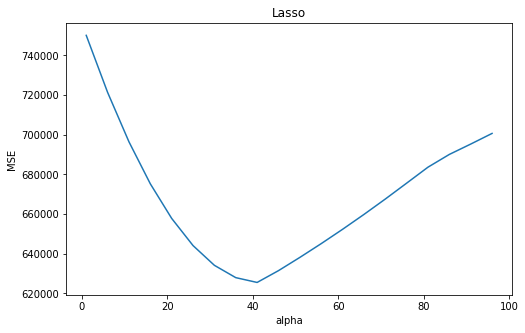

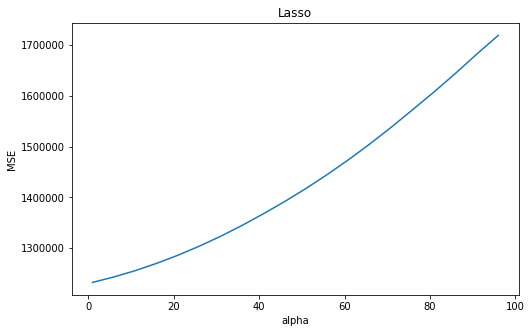

In [21]:
print ('MSE min alpha values', lassocv_reg.alphas_[np.argmin(lassocv_reg.mse_path_, axis = 0)]) #значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам)
for i in range(lassocv_reg.mse_path_.shape[1]): # визуализация столбцов .mse_path_ на отдельных графиках
    plt.figure(figsize=(8, 5))
    plt.plot(lassocv_reg.alphas_, lassocv_reg.mse_path_[:, i])
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.title('Lasso')
    plt.show()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

### Финальные выводы:
Признаки с наибольшими положительными коэффициентами:
- yr - год: в 2012м велопрокат стал более популярен, так что это ожидаемо;
- atemp - температура по ощущениям: наблюдается возрастающая зависимость количества прокатов от температуры;
- season - время года: если смотреть на график, то с весны по осень (1 по 3) наблюдается возрастающая линейная зависимость, однако, зимой количество прокатов падает;
- temp - температура: величина очень близка к atemp и тоже есть зависимость.

Из здравого смысла вполне логично, что чем теплее на улице (переменная season косвенно тоже об этом), тем больше людей хотят взять велосипеды.

Признаки с наибольшими по модулю отрицательными коэффициентами:
- weathersit - погода (1 - хорошая, 4 - очень плохая)
- windspeed(mph) - скорость ветра
- hum - влажность 

Для всех этих показателей видна убывающая линейная зависимость и логично утверждать, что чем хуже погода (в том числе выше скорость ветра и влажность), тем меньше людей хотят покататься на велосипедах.

Есть 2 признака с почти нулевыми коэффициентами windspeed(ms) и mnth. 
Признак windspeed(ms) по сути дублирует информацию в переменной windspeed(mph) (просто другие единицы измерения) и поэтому не несет пользы для модели и имеет нулевой вес.
Логично, что заинтересованность людей в велосипедах зависит от месяца, но модель не учитывает этот признак, поскольку он несет немного дополнительную информацию по сравнению с переменной season (месяц не так важен, как сезон).